In [1]:
import torch
from tqdm import tqdm
from model import Vocaburary, TextGCN
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure
import pickle
SAVE_PATH = './result/R52_Dataset_Label_Number_Effect.result'

c:\Users\Wen2Tee5\Desktop\Postgraduate\final\finalEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run_data(EPOCH, HIDDEN_DIM):
    label_range = range(2, 53)
    labels = []
    max_accs = []
    for label_num in label_range:
        dict_data = torch.load(f'./R52PreprocessData/R{label_num}.gh')
        voc : Vocaburary = dict_data['voc']
        whole_graph = dict_data['whole_graph'].cuda()
        word_num = dict_data['W']
        label_num = dict_data['L']
        doc_num = dict_data['D']
        train_mask = dict_data['train_mask'].cuda()
        doc_Y : torch.Tensor = dict_data['doc_Y'].cuda()
        word_Y : torch.Tensor = dict_data['word_Y'].T.cuda()
        label_Y : torch.Tensor = dict_data['label_Y'].cuda()
        train_words = list(dict_data['train_word'])
        test_words = list(dict_data['test_word'])
        train_words.sort()
        test_words.sort()
        train_num = train_mask.count_nonzero().cpu().item()
        test_num = doc_num - train_num
        print({
            "#DOC":doc_num,
            "#Word":word_num,
            "#Class":label_num,
            "#Train" : train_num,
            "#Test" : test_num,
            "#NODE" : word_num + doc_num + label_num
        })
        log = {"ACC": [], "LOSS": []}
        model = TextGCN(whole_graph.shape[0], HIDDEN_DIM, label_num).cuda()
        optim = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = torch.nn.CrossEntropyLoss()
        trainingProcess = tqdm(range(EPOCH))
        for epoch in trainingProcess:
            total_loss = 0.
            optim.zero_grad()
            y_hat = model(whole_graph)
            doc_Y_hat = y_hat[:doc_num]
            word_Y_hat = y_hat[doc_num:-label_num]
            label_Y_hat = y_hat[doc_num+word_num :]
            doc_loss = loss_fn(doc_Y_hat[train_mask], doc_Y[train_mask])
            word_loss = loss_fn(word_Y_hat[train_words], word_Y[train_words])
            label_loss = loss_fn(label_Y_hat, label_Y)
            loss = 1.0 * doc_loss + 1.0 * word_loss  + 1.0 * label_loss
            loss.backward()
            optim.step()
            loss_val = loss.item()
            with torch.no_grad():
                acc_val = ((doc_Y_hat.argmax(1)[~train_mask] == doc_Y.cuda()[~train_mask]).sum() / (~train_mask).sum()).item()
            trainingProcess.set_postfix({"LOSS": loss_val, "Accuracy":acc_val})
            log['ACC'].append(acc_val)
            log["LOSS"].append(loss_val)
        labels.append(label_num)
        max_accs.append(max(log['ACC']))
    return labels , max_accs

In [3]:
EPOCH = 300
HIDDEN_DIM = 200

In [4]:
label_list = []
max_acc = []

In [5]:
try:
    with open(SAVE_PATH, 'rb') as f:
        result = pickle.load(f)
        label_list = result['label_list']
        max_acc = result['max_acc']
except FileNotFoundError as e:
    (label_list, max_acc) = run_data(EPOCH, HIDDEN_DIM)

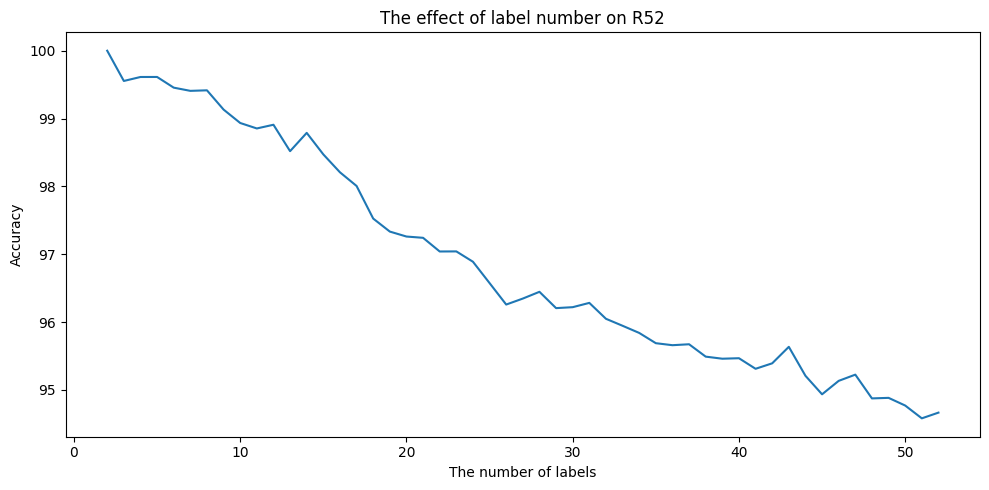

In [7]:
fig : Figure = plt.figure(figsize=(10.,5.))
plt.plot(label_list, list(map(lambda x : x * 100, max_acc)))
plt.title("The effect of label number on R52")
plt.xlabel("The number of labels")
plt.ylabel("Accuracy")
fig.tight_layout()
fig.savefig("./result/R52_Dataset_Label_Number_Effect.svg", transparent = True, format = 'svg')
plt.show()

In [7]:
with open(SAVE_PATH, 'wb') as f:
    pickle.dump({"label_list":label_list, "max_acc": max_acc}, f)

In [8]:
labels = []

In [9]:
for label in range(2, 53):
    dict_data = torch.load(f'./R52PreprocessData/R{label}.gh')
    labels.append(dict_data['doc_Y'])

In [10]:
label_nums = []
for data in labels:
    data : torch.Tensor = data
    label_num = []
    for label in data.unique():
        result : torch.Tensor = (data == label)
        label_num.append(result.count_nonzero().item())
    label_nums.append(label_num)

In [11]:
imbalance_ratio = []
for label_num in label_nums:
    imbalance_ratio.append((max(label_num) - min(label_num)) / max(label_num))
    

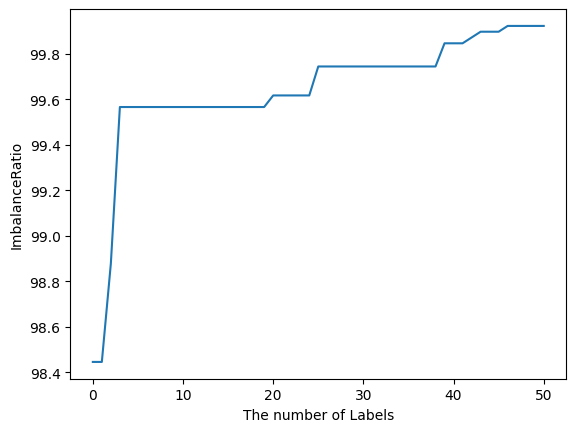

In [12]:
plt.plot(list(map(lambda x : x * 100, imbalance_ratio)))
plt.xlabel("The number of Labels")
plt.ylabel("ImbalanceRatio")
plt.show()